In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

import os
import argparse
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms

from advertorch.utils import predict_from_logits
from advertorch_examples.utils import get_mnist_test_loader
from advertorch_examples.utils import _imshow

from tqdm import tqdm
from time import sleep

import time

from sklearn.preprocessing import normalize
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(0)
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [28]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'val': transforms.Compose([
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
}

data_dir = 'data/data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [29]:
#model_ft = models.resnet18(pretrained=True)
#num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
#model_ft.fc = nn.Linear(num_ftrs, len(class_names))

#model_ft = model_ft.to(device)


In [31]:
epsilons = [0, .05, .1, .15, .2, .25, .3]
filename = "models/resnet_model_acc_95.pt"
use_cuda=True
device = torch.device('cuda')

In [32]:
import torchvision.models as models
model_ft = models.resnet18(pretrained=True).to(device)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names)).to(device)

# Load the pretrained model
model_ft.load_state_dict(torch.load(filename, map_location='cpu'))
# Set the model in evaluation mode. In this case this is for the Dropout layers
model_ft.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [33]:
from torchvision import datasets, transforms

test_transforms = transforms.Compose([#transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
                                      #transforms.CenterCrop(size=256),
                                      #transforms.ToPILImage(),
                                      transforms.Resize((224,224)),
                                      
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])


                                      #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
test_transforms= transforms.Compose([
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
test_data = datasets.ImageFolder('data/data/test/', test_transforms)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=5,shuffle=True)

In [34]:
print (class_names)

['go', 'goForward', 'goLeft', 'stop', 'stopLeft', 'warning', 'warningLeft']


In [35]:
for cln_data, true_label in test_loader:
    #print (cln_data,true_label)
    print (true_label)
    break

print (torch.min(cln_data[0]))

tensor([3, 0, 0, 3, 3])
tensor(-2.1179)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


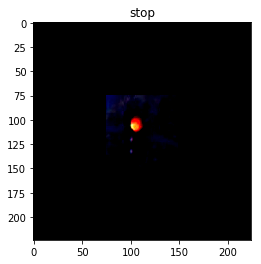

In [36]:
#print ((cln_data[0].permute(1, 2, 0)))
c_cln_data = cln_data.cpu()
#c_true_label = true_label.copy()
plt.imshow((c_cln_data[0].permute(1, 2, 0)*0.5 + 0.5))
plt.title(class_names[true_label[0]])
plt.show()

### Fast Gradiant Sign Method

In [37]:
from advertorch.attacks import GradientSignAttack
adversary = GradientSignAttack(model_ft,eps=0.25)

In [38]:
sign_types = class_names

wrong_count = 0
total_count  = 0 
ad_unt_wrong = 0
ad_t_wrong = 0

total_length = len(test_loader)
count = 0

dict_adv_count = {key: 0 for key in sign_types}
dict_total_count = {key: 0 for key in sign_types}
dict_cln_count = {key: 0 for key in sign_types}

dict_vis_adv = {key: 0 for key in sign_types}
dict_vis_cln = {key: 0 for key in sign_types}

error_count = [[0 for i in range(len(sign_types))] for j in range(len(sign_types))]


# for visulization
true_data = []
advr_imgs = []
true_label = []
advr_label = []
advr_perct = []

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0) # only difference

import sys    
def show_progress(i,end_val, bar_length=20):
    percent = float(i) / end_val
    hashes = '#' * int(round(percent * bar_length))
    spaces = ' ' * (bar_length - len(hashes))
    sys.stdout.write("\rPercent: [{0}] {1}%".format(hashes + spaces, int(round(percent * 100))))
    sys.stdout.flush()
    
    
for cln_data, true_label in test_loader:
    
    start = time.time()
    
    cln_data, true_label = cln_data.to(device), true_label.to(device)
    adversary = GradientSignAttack(model_ft,eps=0.25)
    
    # prediction on adversrila data.
    adv_untargeted = adversary.perturb(cln_data, true_label)
    preds = model_ft(adv_untargeted)
    pred_untargeted_adv = predict_from_logits(preds)
    
    # prediction without attack
    pred_cln = predict_from_logits(model_ft(cln_data))
    
    for ii in range(len(true_label)):
        total_count+=1
        dict_total_count[sign_types[true_label[ii]]]+=1
    
        if(true_label[ii]!=pred_cln[ii]):
            wrong_count+=1
            dict_cln_count[sign_types[true_label[ii]]]+=1
                
        if(pred_untargeted_adv[ii]!=true_label[ii]):
            ad_unt_wrong+=1
            dict_adv_count[sign_types[true_label[ii]]]+=1
            
            # save samples in list
            #if(dict_vis_adv[sign_types[true_label[ii]]]==0):
            #    dict_vis_adv[sign_types[true_label[ii]]] = 
                        
        i = sign_types.index(sign_types[true_label[ii]])
        j = sign_types.index(sign_types[pred_untargeted_adv[ii]])
        error_count[i][j]+=1
        
        # calculate the prediction percentage here.
        c_true_label = true_label.cpu()
        adv = adv_untargeted[ii].cpu()
        
        pred_percentage = softmax(preds.cpu()[ii].detach().numpy())*100.0
        idx = np.argmax(pred_percentage)
        per = np.max(pred_percentage)
        
        advr_imgs.append(adv_untargeted.cpu()[ii].detach().numpy())
        advr_label.append(idx)
        advr_perct.append(per)
        
        break
            
    count+=1
    end = time.time()
    show_progress(count,total_length)

Percent: [####################] 100%

In [39]:
dict_adv_count

{'go': 54,
 'goForward': 0,
 'goLeft': 1,
 'stop': 46,
 'stopLeft': 13,
 'warning': 5,
 'warningLeft': 0}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


itr :  0	Pred :  tensor([2, 4, 2, 2, 0], device='cuda:0')
2 85.0088 goLeft


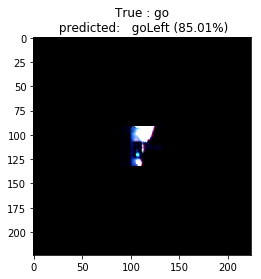

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4 84.38867 stopLeft


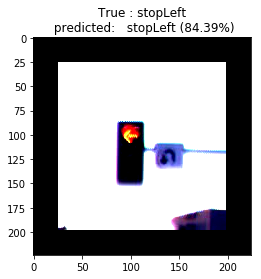

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2 96.07218 goLeft


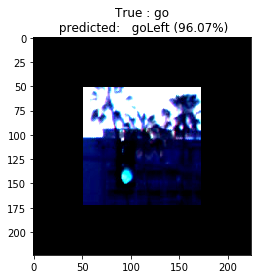

2 66.24406 goLeft


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


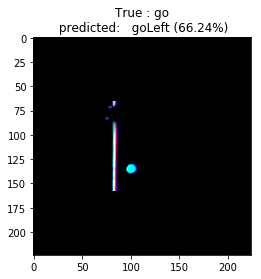

0 25.3346 go


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


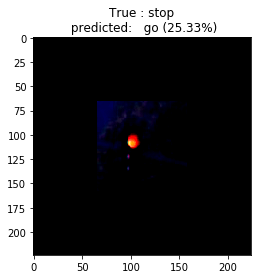

In [42]:
count = 0
for cln_data, true_label in test_loader:
    print ('itr : ', count , end='\t')
    count+=1
    
    # creat the attack.
    #cln_data, true_label = cln_data.to(device), true_label.to(device)
    cln_data, true_label = cln_data.to(device), true_label.to(device)
    adv_untargeted = adversary.perturb(cln_data, true_label)
    
    # prediction on adversrila data.
    preds = model_ft(adv_untargeted)
    pred_untargeted_adv = predict_from_logits(preds)
    
    #print ('True : ' , true_label)
    print ('Pred : ' , pred_untargeted_adv)
    
    for ii in range(0,len(true_label)):
        c_cln_data = cln_data.cpu()
        c_true_label = true_label.cpu()
        adv = adv_untargeted[ii].cpu()
        
        pred_percentage = softmax(preds.cpu()[ii].detach().numpy())*100.0
        idx = np.argmax(pred_percentage)
        per = np.max(pred_percentage)
        
        print (idx , per , sign_types[idx])
    
        
        plt.imshow((c_cln_data[ii].permute(1, 2, 0)*0.5 + 0.5).detach().numpy())
        title = 'True : ' + sign_types[c_true_label[ii]]+ '\n predicted:   ' + sign_types[pred_untargeted_adv[ii]] + ' ('+ '%.2f' % per + '%)'
        #plt.title(sign_types[c_true_label[ii]])
        plt.title(title)
        plt.show()
        
        #plt.imshow((adv.permute(1, 2, 0)*0.5 + 0.5).detach().numpy())
        #title = 'True : ' + sign_types[c_true_label[ii]]+ '\n predicted:   ' + sign_types[pred_untargeted_adv[ii]] + ' ('+ '%.2f' % per + '%)'
        #plt.title(title)
        #plt.show()
        
        #print (true_label[ii])
    
    if(count==1): break

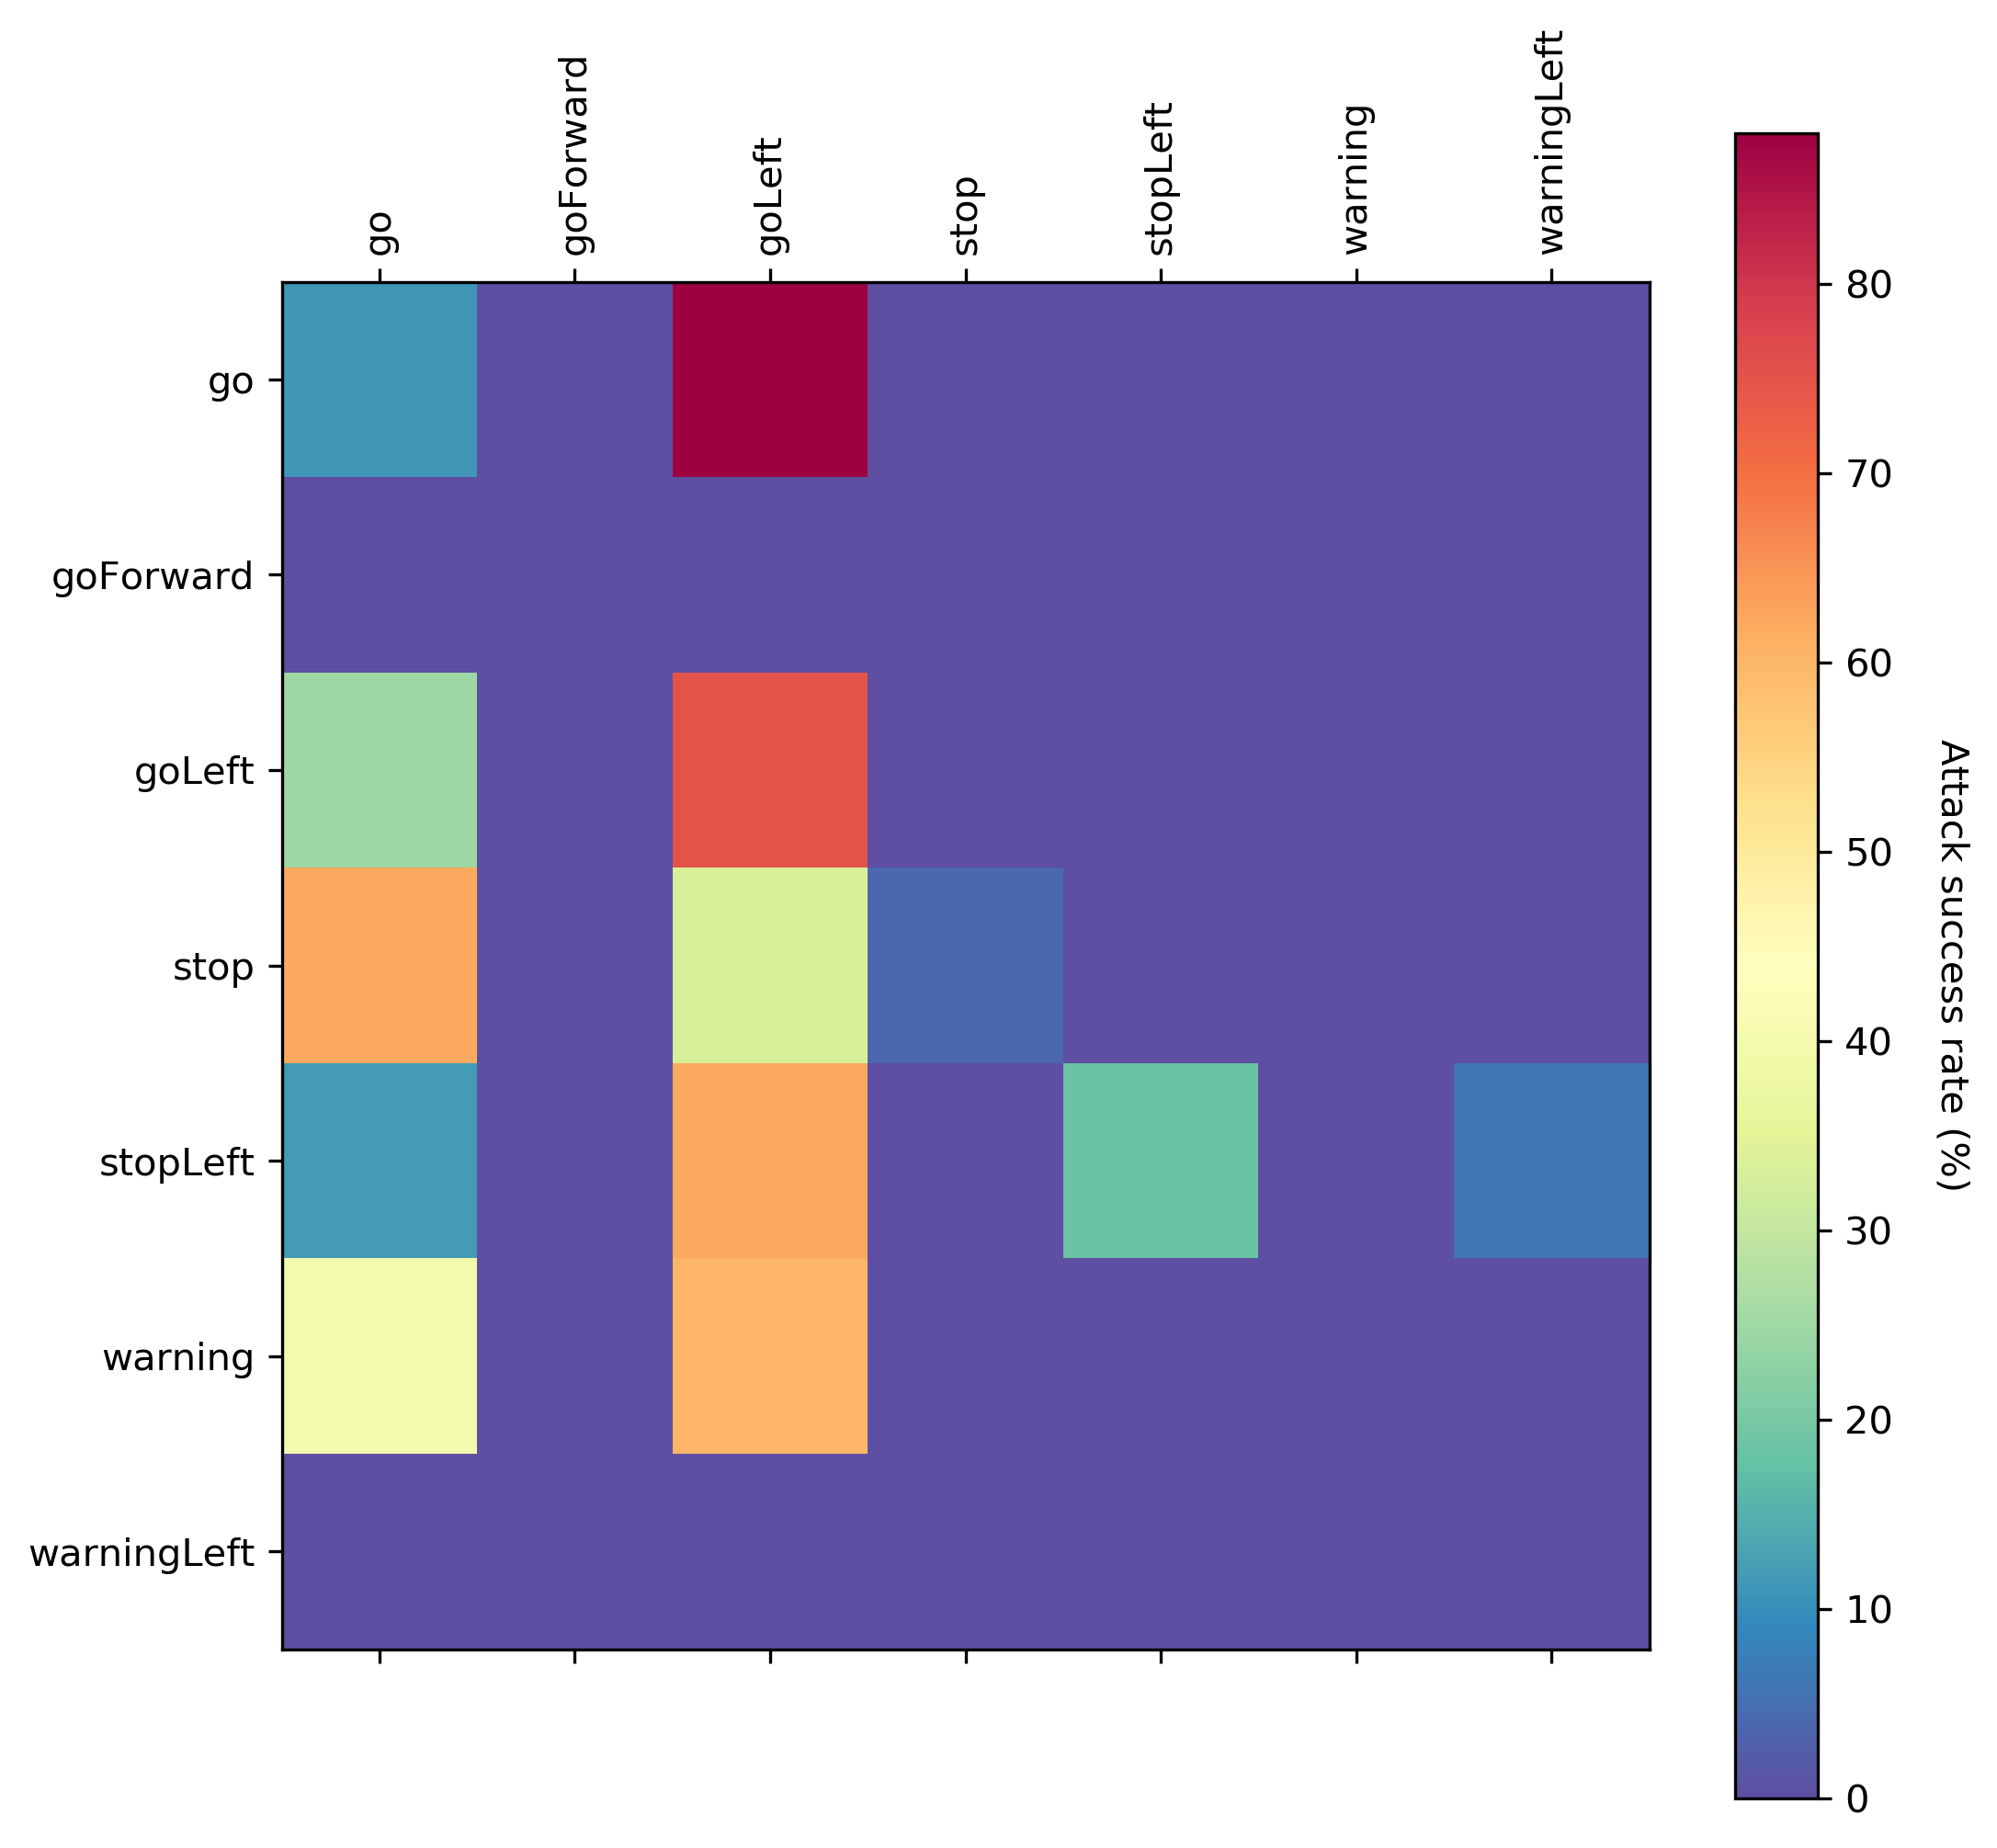

In [46]:
from sklearn.preprocessing import normalize
matrix = np.array(error_count).astype(np.float64)
normed_matrix = normalize(matrix, axis=1, norm='l1')

error_mat = (normed_matrix*100).astype('int')
## show

alpha = sign_types
data = error_mat #np.random.random((4,4))
fig = plt.figure(figsize=(8, 8), dpi=300)
ax = fig.add_subplot(111)
cax = ax.matshow(data,cmap=plt.cm.Spectral_r)

#fig.colorbar(cax)

cbar = fig.colorbar(cax)
cbar.set_label('Attack success rate (%)', rotation=270,labelpad=20)

ax.set_xticklabels(alpha)
ax.set_yticklabels(alpha)
ax.set_xticks(np.arange(len(alpha)))
ax.set_yticks(np.arange(len(alpha)))
plt.xticks(rotation=90)

plt.savefig('images/confusion_matrix_cw.png',dpi=300,bbox_inches = 'tight')
plt.show()